<a href="https://colab.research.google.com/github/bghaendler/Data-Analysis/blob/master/Fraud_Detection_with_Synthetic_Financial_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection with Synthetic Financial Datasets 

In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1: Import Data from Kaggle

In [1]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [2]:
!kaggle datasets download ntnu-testimon/paysim1 --unzip 

 98% 178M/182M [00:01<00:00, 84.8MB/s]
100% 182M/182M [00:01<00:00, 107MB/s] 


* This dataset is presently only one of four on Kaggle with information on the **rising risk of digital financial fraud**, emphasizing the difficulty in obtaining such data. 
* The main technical challenge it poses to predicting fraud is the **highly imbalanced distribution between positive and negative classes** in 6 million rows of data. 
* Another stumbling block to the utility of this data stems from the **possible discrepancies in its description**. 
* The goal of this analysis is 
 * to solve both these issues by a detailed data exploration and cleaning followed by 
 * choosing a suitable machine-learning algorithm to deal with the skew. 
* I show that an optimal solution based on feature-engineering and e**xtreme gradient-boosted decision trees yields an enhanced predictive power of 0.997, as measured by the area under the precision-recall curve**. 
* Crucially, these results were obtained without artificial balancing of the data making this approach suitable to real-world applications.

# 2: Exploratory Data Analysis

In [0]:
pd.options.display.float_format = '${:,.2f}'.format

In [0]:
df_full = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df_full = df_full.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [5]:
df_full.sort_values("nameOrig").head(10)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
3196942,249,CASH_OUT,"$244,486.46",C1000000639,"$8,946.00",$0.00,C785826240,"$526,950.37","$771,436.84",0,0
2798983,217,PAYMENT,"$3,170.28",C1000001337,"$58,089.00","$54,918.72",M216466820,$0.00,$0.00,0,0
1013585,46,PAYMENT,"$8,424.74",C1000001725,$783.00,$0.00,M1974356374,$0.00,$0.00,0,0
2980283,231,CASH_IN,"$261,877.19",C1000002591,"$7,596.00","$269,473.19",C503690069,"$1,126,627.70","$864,750.51",0,0
1920204,167,CASH_IN,"$20,528.65",C1000003372,"$2,302,074.12","$2,322,602.77",C1840417793,"$82,696.17","$62,167.52",0,0
3374567,254,CASH_IN,"$49,360.77",C1000003615,"$1,472,658.31","$1,522,019.07",C996088808,"$935,378.26","$886,017.50",0,0
4548211,327,CASH_OUT,"$211,189.64",C1000004053,$0.00,$0.00,C1128041097,"$2,609,840.34","$2,821,029.98",0,0
847860,41,CASH_OUT,"$93,865.13",C1000004530,"$351,422.72","$257,557.59",C1643839147,"$178,083.14","$271,948.26",0,0
2825292,226,TRANSFER,"$3,228,390.11",C1000005353,"$24,996.00",$0.00,C292963054,"$878,327.64","$4,106,717.75",0,0
2202461,185,CASH_OUT,"$233,109.79",C1000005555,"$20,623.00",$0.00,C1091802600,$0.00,"$233,109.79",0,0


In [7]:
df_full.isFraud.value_counts() 

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
df_full.isFlaggedFraud.value_counts() 

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

Descriptive Analysis of the DataFrame

In [9]:
df_full.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,"$6,362,620.00","$6,362,620.00","$6,362,620.00","$6,362,620.00","$6,362,620.00","$6,362,620.00","$6,362,620.00","$6,362,620.00"
mean,$243.40,"$179,861.90","$833,883.10","$855,113.67","$1,100,701.67","$1,224,996.40",$0.00,$0.00
std,$142.33,"$603,858.23","$2,888,242.67","$2,924,048.50","$3,399,180.11","$3,674,128.94",$0.04,$0.00
min,$1.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
25%,$156.00,"$13,389.57",$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
50%,$239.00,"$74,871.94","$14,208.00",$0.00,"$132,705.66","$214,661.44",$0.00,$0.00
75%,$335.00,"$208,721.48","$107,315.18","$144,258.41","$943,036.71","$1,111,909.25",$0.00,$0.00
max,$743.00,"$92,445,516.64","$59,585,040.37","$49,585,040.37","$356,015,889.35","$356,179,278.92",$1.00,$1.00


Test if there any missing values in DataFrame. It turns out there are no obvious missing values but, as we will see below, this does not rule out proxies by a numerical value like 0.

In [89]:
df_full.isnull().values.sum()

0

* In this section, we wrangle with the data exclusively using Dataframe methods. 
* This is the most succinct way to gain insights into the dataset. 
* More elaborate visualizations follow in subsequent sections.

## 2.1 Which types of transactions are fraudulent?
* We find that of the f**ive types of transactions**, *fraud occurs only in two of them* (see also kernels by Net, Philipp Schmidt and Ibe_Noriaki): 
 * '**TRANSFER**' where money is sent to a customer / fraudster and 
 *  '**CASH_OUT**' where money is sent to a merchant who pays the customer / fraudster in cash. 
* Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (see the right half of the plot in section 5.1). 
* These observations appear, at first, to bear out the description provided on Kaggle for the modus operandi of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out. 
* We will return to this issue later in section 2.4


In [90]:
print('The types of fraudulent transactions are {}'.format(\
list(df_full.loc[df_full.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df_full.loc[(df_full.isFraud == 1) & (df_full.type == 'TRANSFER')]
dfFraudCashout = df_full.loc[(df_full.isFraud == 1) & (df_full.type == 'CASH_OUT')]

print ('The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097
print ('The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116

The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']
The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116


## 2.2. What determines whether the feature isFlaggedFraud gets set or not?
* It turns out that **the origin of isFlaggedFraud is unclear**, contrasting with the description provided. 
 * The 16 entries (out of 6 million) where the isFlaggedFraud feature is set **do not seem to correlate with any explanatory variable**. 
 * The data is described as isFlaggedFraud being set when an attempt **is made to 'TRANSFER' an 'amount' greater than 200,000**. 
   * In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [91]:
print('The type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df_full.loc[df_full.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df_full.loc[df_full.type == 'TRANSFER']
dfFlagged = df_full.loc[df_full.isFlaggedFraud == 1]
dfNotFlagged = df_full.loc[df_full.isFlaggedFraud == 0]

print('Min amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22
print('Max amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.max())) # 353874.22
print('Mean amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.mean())) # 353874.22
print('Max amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64
print('Mean amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.mean())) # 92445516.64

The type of transactions in which isFlaggedFraud is set: ['TRANSFER']
Min amount transacted when isFlaggedFraud is set= 353874.22
Max amount transacted when isFlaggedFraud is set= 10000000.0
Mean amount transacted when isFlaggedFraud is set= 4861597.730625
Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64
Mean amount transacted in a TRANSFER where isFlaggedFraud is not set= 910528.3831828752


* **Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set? **
 * The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. 
 * This is **presumably because the transaction is halted** [4]. 
 * Interestingly, oldBalanceDest = 0 in every such transaction. 
 * However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [93]:
dfTransfer.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [94]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
      format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceOrig == 0)])))


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 60821


* isFlaggedFraud being set cannot be thresholded on oldBalanceOrig since the corresponding range of values overlaps with that for TRANSFERs where isFlaggedFraud is not set (see below). 
* Note that we do not need to consider newBalanceOrig since it is updated only after the transaction, whereas isFlaggedFraud would be set before the transaction takes place.

In [96]:
print('Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))

Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874.0, 19585040.0]
Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668.0]


* Can isFlaggedFraud be set based on seeing a customer transacting more than once? 
 * Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. 
 * It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. 
 * Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.





In [99]:
print('Have originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) # False

print('Have destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) # False

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('How many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) # 2

Have originators of transactions flagged as fraud transacted more than once? False
Have destinations for transactions flagged as fraud initiated other transactions? False
How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


* It can be easily seen that transactions with isFlaggedFraud set occur at all values of step, similar to the complementary set of transactions. 
* Thus isFlaggedFraud does not correlate with step either and is therefore seemingly unrelated to any explanatory variable or feature in the data

**Conclusion:** 
* Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, **we can treat this feature as insignificant and discard it in the dataset without loosing information.**

## 2.3. Are expected merchant accounts accordingly labelled?

* It was stated [5] that CASH_IN involves being paid by a merchant (whose name is prefixed by 'M'). 
 * However, as shown below, the present data does not have merchants making CASH_IN transactions to customers.

In [100]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df_full.loc[df_full.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


* Similarly, it was stated that CASH_OUT involves paying a merchant. However, for CASH_OUT transactions there are no merchants among the destination accounts.

In [103]:
print('Are there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df_full.loc[df_full.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False

Are there any merchants among destination accounts for CASH_OUT transactions? False


* In fact, there are no merchants among any originator accounts. Merchants are only present in destination accounts for all PAYMENTS.

In [104]:
print('Are there merchants among any originator accounts? {}'.format(\
      df_full.nameOrig.str.contains('M').any())) # False

print('Are there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df_full.loc[df_full.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False

Are there merchants among any originator accounts? False
Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


* Conclusion: Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

## 2.4. Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?
* From the data description, the modus operandi for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. 
* CASH_OUT involves transacting with a merchant who pays out cash. 
* Thus, within this two-step process, **the fraudulent account would be both**, the destination in a TRANSFER and the originator in a CASH_OUT. 
* However, the data shows below that there are no such common accounts among fraudulent transactions. 
* Thus, the data is not imprinted with the expected modus-operandi.

In [105]:
print('Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df_full.loc[df_full.isFraud == 0]

Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


* Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine? It turns out there are 3 such accounts.

In [106]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type        amount  ... newBalanceDest  isFraud  isFlaggedFraud
1030443    65  TRANSFER $1,282,971.57  ...          $0.00        1               0
6039814   486  TRANSFER   $214,793.32  ...          $0.00        1               0
6362556   738  TRANSFER   $814,689.88  ...          $0.00        1               0

[3 rows x 11 columns]


In [109]:
dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
1030443,65,TRANSFER,"$1,282,971.57",C1175896731,"$1,282,971.57",$0.00,C1714931087,$0.00,$0.00,1,0
6039814,486,TRANSFER,"$214,793.32",C2140495649,"$214,793.32",$0.00,C423543548,$0.00,$0.00,1,0
6362556,738,TRANSFER,"$814,689.88",C2029041842,"$814,689.88",$0.00,C1023330867,$0.00,$0.00,1,0


* However, 2 out of 3 of these accounts first make a genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. 
**Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.**

**Conclusion: **
* Noting from section 2.3 above that the nameOrig and nameDest features neither encode merchant accounts in the expected way, below, we drop these features from the data since they are meaningless.

# 3: Data cleaning

* From the exploratory data analysis (EDA) of section 2, we know that **fraud only occurs in 'TRANSFER's and 'CASH_OUT's**. 
So we assemble only the corresponding data in X for analysis.

In [0]:
X = df_full.loc[(df_full.type == 'TRANSFER') | (df_full.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [0]:
X.head(10)

In [0]:
Y.head(10)

## 3.1. Imputation of Latent Missing Values
* The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. 
* The fraction of such transactions, where zero likely **denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).**

In [12]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('The fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('The fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072
The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [118]:
XnonFraud.head(10)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
15,1,1,"$229,133.94","$15,325.00",$0.00,"$5,083.00","$51,513.44"
19,1,0,"$215,310.30",$705.00,$0.00,"$22,425.00",$0.00
24,1,0,"$311,685.89","$10,835.00",$0.00,"$6,267.00","$2,719,172.89"
42,1,1,"$110,414.71","$26,845.41",$0.00,"$288,800.00","$2,415.16"
47,1,1,"$56,953.90","$1,942.02",$0.00,"$70,253.00","$64,106.18"
48,1,1,"$5,346.89",$0.00,$0.00,"$652,637.00","$6,453,430.91"
51,1,1,"$23,261.30","$20,411.53",$0.00,"$25,742.00",$0.00
58,1,0,"$62,610.80","$79,114.00","$16,503.20",$517.00,"$8,383.29"
60,1,1,"$82,940.31","$3,017.87",$0.00,"$132,372.00","$49,864.36"
70,1,1,"$47,458.86","$209,534.84","$162,075.98","$52,120.00",$0.00


In [117]:
Xfraud.head(10)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,$181.00,$181.00,$0.00,$0.00,$0.00
3,1,1,$181.00,$181.00,$0.00,"$21,182.00",$0.00
251,1,0,"$2,806.00","$2,806.00",$0.00,$0.00,$0.00
252,1,1,"$2,806.00","$2,806.00",$0.00,"$26,202.00",$0.00
680,1,0,"$20,128.00","$20,128.00",$0.00,$0.00,$0.00
681,1,1,"$20,128.00","$20,128.00",$0.00,"$6,268.00","$12,145.85"
724,1,1,"$416,001.33",$0.00,$0.00,$102.00,"$9,291,619.62"
969,1,0,"$1,277,212.77","$1,277,212.77",$0.00,$0.00,$0.00
970,1,1,"$1,277,212.77","$1,277,212.77",$0.00,$0.00,"$2,444,985.19"
1115,1,0,"$35,063.63","$35,063.63",$0.00,$0.00,$0.00


In [0]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [0]:
X.head()

In [0]:
The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.

* The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. 
* In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). 
* Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.

In [0]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

In [0]:
X.head(10)

# 4. Feature-engineering
* Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we take the data-imputation of section 3.1 a step further and create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. 
* These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [0]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [0]:
X.head(10)

# 5. Data visualization
* The best way of confirming that the data contains enough information so that a ML algorithm can make strong predictions, is to try and directly **visualize the differences between fraudulent and genuine transactions.** 
* Motivated by this principle, I visualize these differences in several ways in the plots below.

In [0]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

## 5.1. Dispersion over time
* The plot below shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. 
 * It is clear that **fradulent transactions are more homogenously distributed over time compared to genuine transactions**. 
 * Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. 
* Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae.

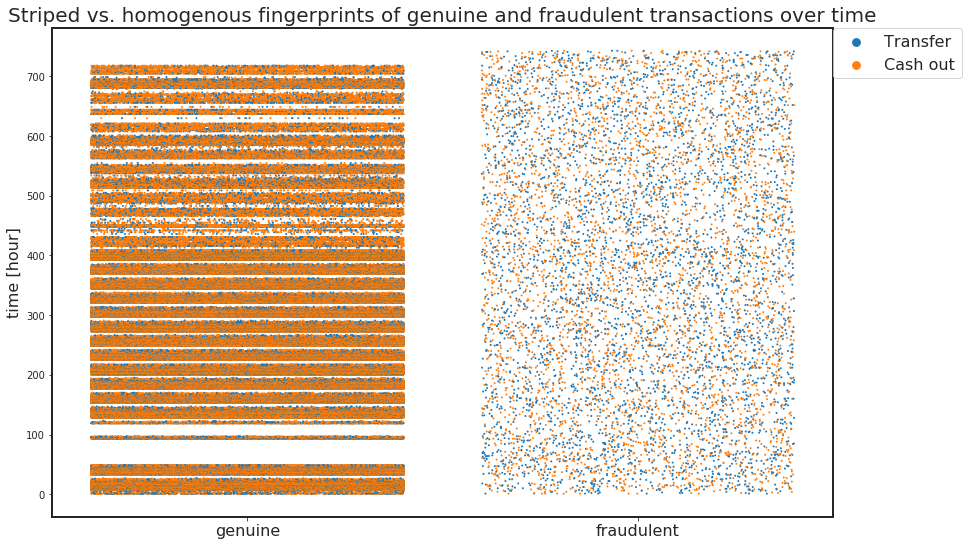

In [142]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

## 5.2. Dispersion over amount
* The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.

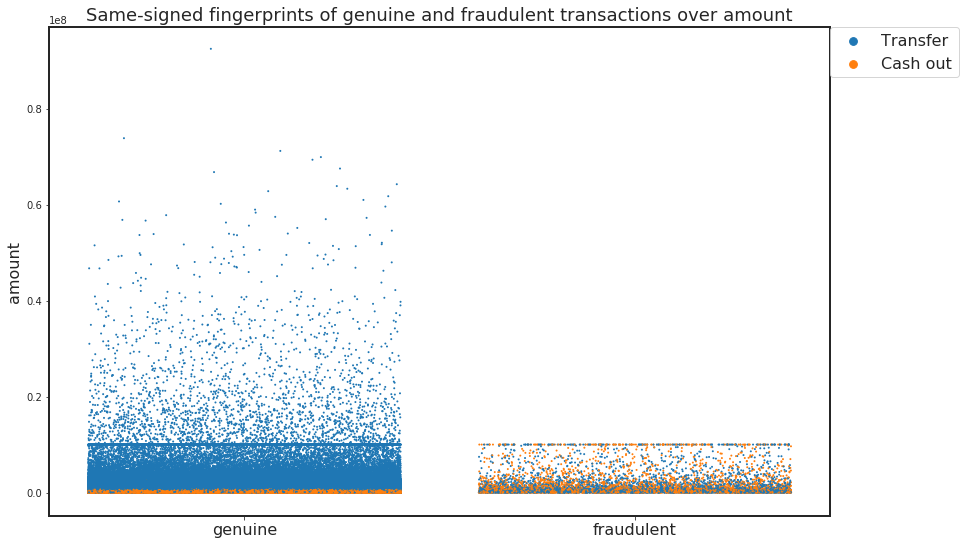

In [143]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

## 5.3. Dispersion over error in balance in destination accounts

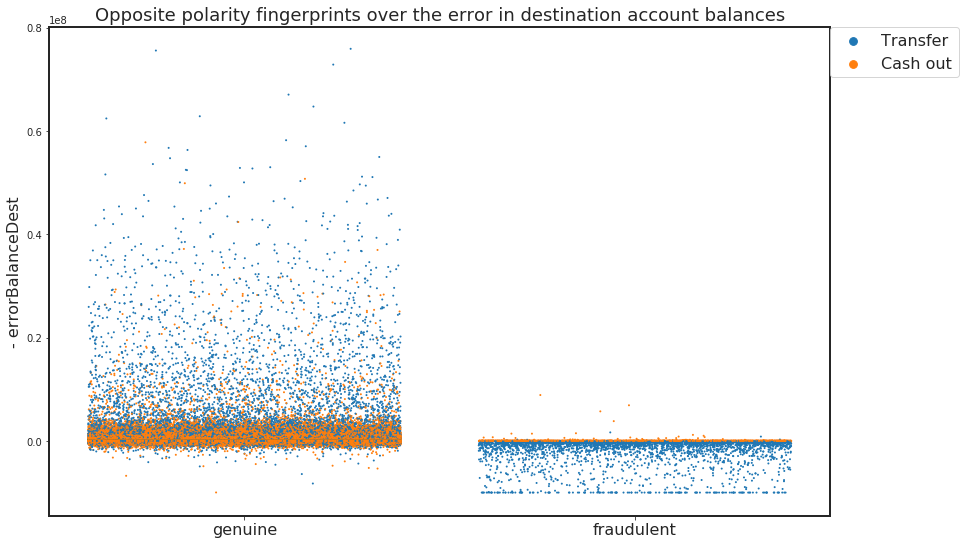

In [144]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

## 5.4. Separating out genuine from fraudulent transactions
* The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step feature is ineffective in seperating out fraud. Note the striped nature of the genuine data vs time which was aniticipated from the figure in section 5.1.

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


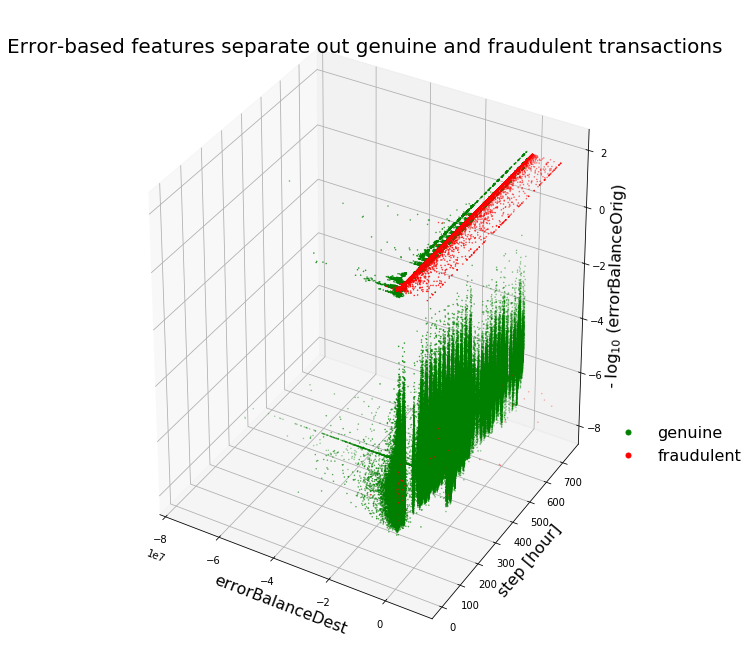

In [15]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

## 5.5. Fingerprints of genuine and fraudulent transactions
* Smoking gun and comprehensive evidence embedded in the dataset of the difference between fraudulent and genuine transactions is obtained by examining their respective correlations in the heatmaps below.

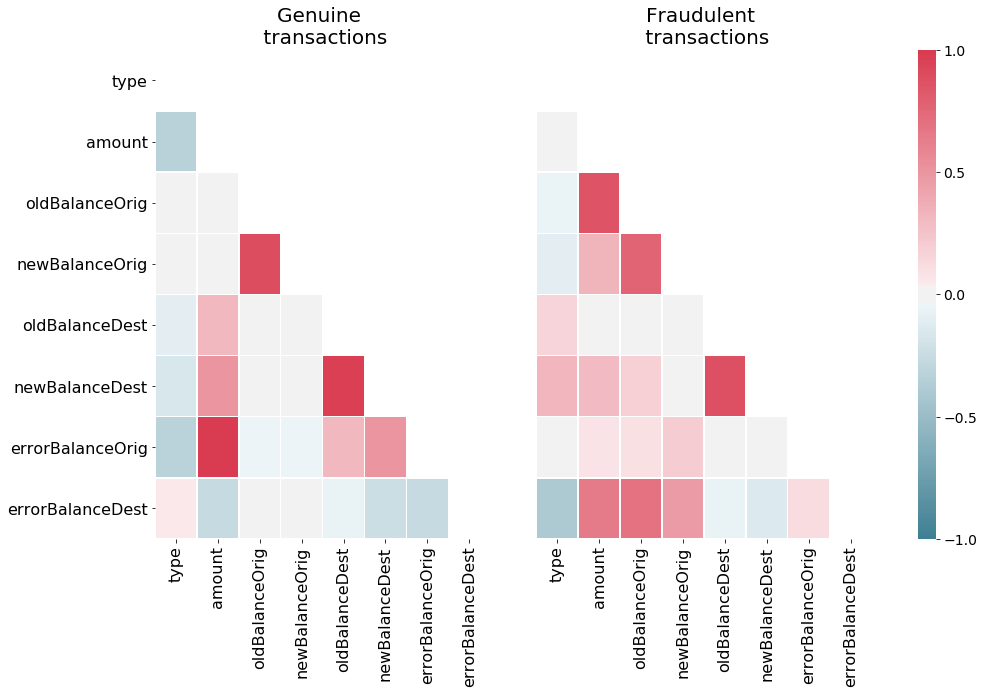

In [16]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

# 6: Machine Learning to Detect Fraud in Skewed Data
* Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data.


In [17]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


* Selection of metric: 
 * Since the data is **highly skewed**, I use the **area under the precision-recall curve** (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC). 
 * This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC (see Davis and Goadrich, 2006).

* **Selection of ML algorithm**: 
 * A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. 
 * The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. 
 * A better approach might be to **oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library**. 
   * Motivated by this, I tried a variety of **anomaly-detection and supervised learning approaches**. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on **ensembles of decision trees that intrinsically performs well on imbalanced data**. 
   * Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. 
   * Among these algorithms, the **extreme gradient-boosted (XGBoost)** algorithm used below slightly outperforms random-forest. 
   * Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

* Split the data into training and test sets in a 80:20 ratio

In [0]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [22]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 8, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

AUPRC = 0.997774085853017


## 6.1. What are the important features for the ML model?

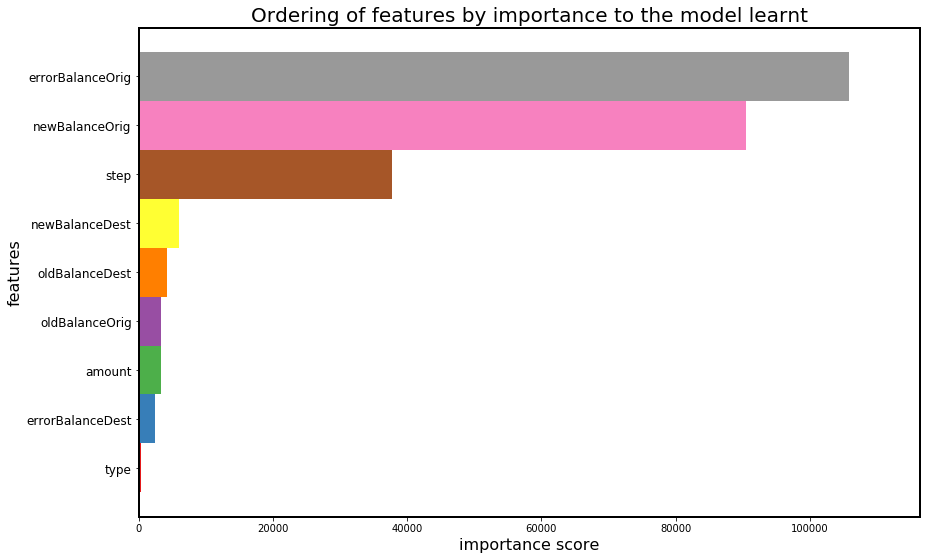

In [23]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

## 6.2. Visualization of ML model
* The root node in the decision tree visualized below is indeed the feature errorBalanceOrig, as would be expected from its high significance to the model.

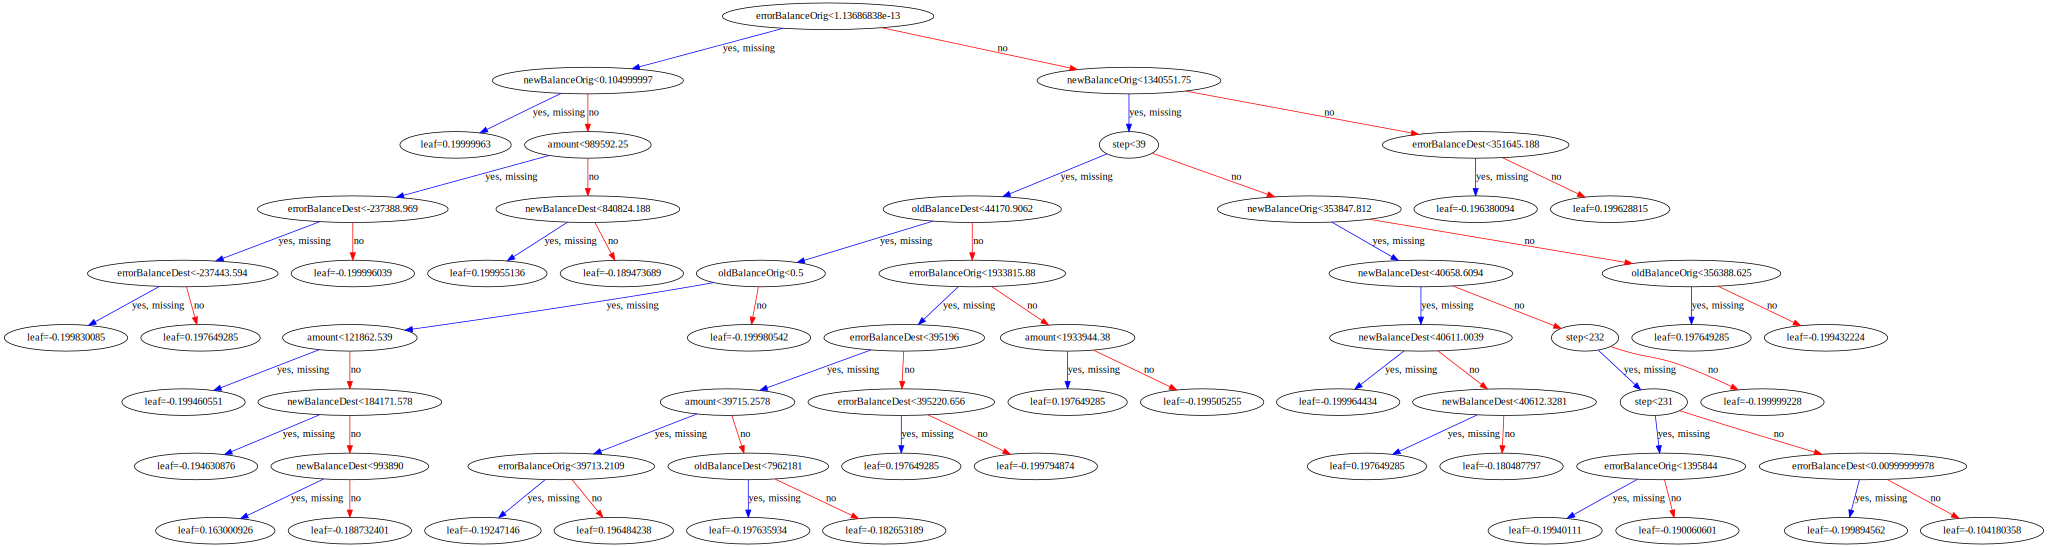

In [24]:
to_graphviz(clf)

## 6.3. Bias-variance tradeoff
* The model we have learnt has a **degree of bias and is slighly underfit**. 
* This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. 
* The easiest way to improve the performance of the model still further is to increase the max_depth parameter of the XGBClassifier at the expense of the longer time spent learning the model. 
* Other parameters of the classifier that can be adjusted to correct for the effect of the modest underfitting include decreasing min_child_weight and decreasing reg_lambda.

In [25]:
# Long computation in this cell (~6 minutes)

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


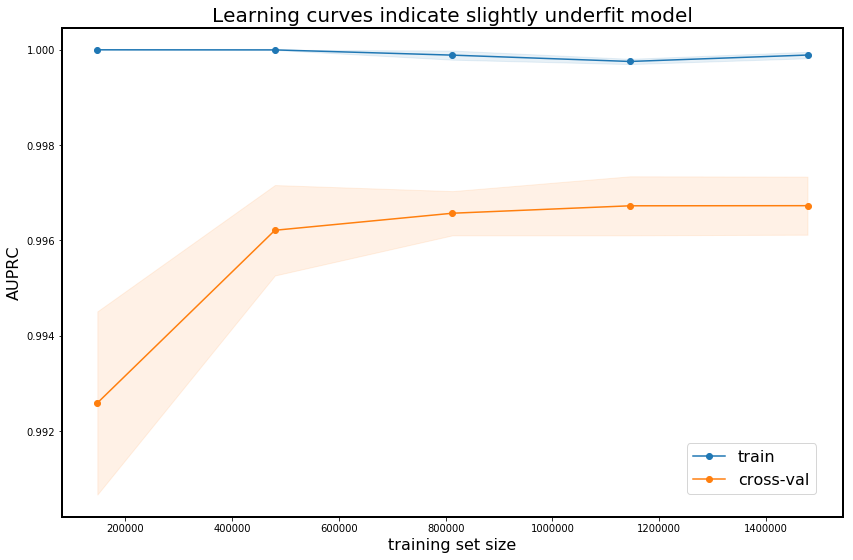

In [26]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

# 7: Conclusions
* We thoroughly interrogated the data at the outset to gain insight into which features could be discarded and those which could be valuably engineered. 
* The plots provided visual confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with the large skew in the data, we chose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with strongly imbalanced classes. 
* The method used in this kernel should therefore be broadly applicable to a range of such problems.